# DyNet vs PyTorch

In [1]:
%matplotlib inline
from random import choice, randrange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import random

EOS = "<EOS>" #all strings will end with the End Of String token
PAD = "<PAD>"
characters = list("abcd")
characters.append(EOS)
characters.append(PAD)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)
PAD_IDX = VOCAB_SIZE - 1

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-2]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse
    

MIN_STRING_LEN = 1
MAX_STRING_LEN = 10
TRAIN_SET_SIZE = 5000
VAL_SET_SIZE = 10

batch_size = 1

RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
STATE_SIZE = 64

default_epochs = 20

learning_rate = 0.1

train_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(TRAIN_SET_SIZE)]
val_set = [sample_model(MIN_STRING_LEN, MAX_STRING_LEN) for _ in range(VAL_SET_SIZE)]

# PyTorch Attention Model

In [2]:
def _preprocess_string(strings):
    strings_with_eos = [list(string) + [EOS] for string in strings]
    max_len = max([len(string) for string in strings_with_eos])
    padded_strings = [string + [PAD] * (max_len - len(string)) for string in strings_with_eos]
    int_strings = [[char2int[c] for c in string] for string in padded_strings]
    var = Variable(torch.LongTensor(int_strings))
    return var


def get_loss(network, input_strings, output_strings):
    batch_size = len(output_strings)

    input_strings_t = _preprocess_string(input_strings)
    output_strings_t = _preprocess_string(output_strings)

    probs = network(input_strings_t, batch_size).permute(1, 0, 2)

    loss = sum([F.cross_entropy(p, t, ignore_index=PAD_IDX) for p, t in zip(probs, output_strings_t)])

    return loss


def generate(network, input_string):
    input_string = _preprocess_string([input_string])
    probs = network(input_string, 1)
    generated = [int2char[prob[0].topk(1)[1][0]] for prob in probs.data]
    return (''.join(generated)).split(EOS)[0].replace(PAD, '')


def train(network, train_set, val_set, epochs=default_epochs):
    def get_val_set_loss(network, val_set):
        batch_inputs, batch_outputs = [], []
        losses = 0
        for input_string, output_string in val_set:
            batch_inputs.append(input_string), batch_outputs.append(output_string)
            if len(batch_inputs) == batch_size:
                losses += get_loss(network, batch_inputs, batch_outputs).data[0]
                batch_inputs, batch_outputs = [], []
        return losses

    def step(optim, network, batch_inputs, batch_outputs):
        optim.zero_grad()
        loss = get_loss(network, batch_inputs, batch_outputs)
        loss.backward()
        optim.step()

    train_set = train_set * epochs
    losses = []
    iterations = []
    optim = torch.optim.SGD(network.parameters(), lr=learning_rate)

    batch_inputs, batch_outputs = [], []
    for i, (input_string, output_string) in enumerate(tqdm(train_set)):
        batch_inputs.append(input_string), batch_outputs.append(output_string)
        if len(batch_inputs) == batch_size:
            step(optim, network, batch_inputs, batch_outputs)
            batch_inputs, batch_outputs = [], []

        # Accumulate average losses over training to plot
        if i % int(len(train_set) / 100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i / ((len(train_set) / 100)))
    if batch_inputs: step(optim, network, batch_inputs, batch_outputs)

    plt.plot(iterations, losses)
    # plt.axis([0, 100, 0, len(val_set)*MAX_STRING_LEN]])
    plt.show()
    print('loss on validation set:', val_loss)

In [3]:
class AttentionPyTorch(nn.Module):
    def __init__(self, embeddings_size, state_size):
        super(AttentionPyTorch, self).__init__()
        self.state_size = state_size

        self.embeddings = nn.Embedding(VOCAB_SIZE, embeddings_size, padding_idx=PAD_IDX)

        self.enc = nn.LSTM(embeddings_size, state_size, 1)
        self.dec = nn.LSTM(state_size, state_size, 1)

        self.att_w1 = nn.Linear(state_size, state_size, bias=False)
        self.att_w2 = nn.Linear(state_size, state_size, bias=False)
        self.att_v = nn.Linear(state_size, 1, bias=False)

        self.linear = nn.Linear(state_size, VOCAB_SIZE)

    def get_rnn_init_state(self, batch_size):
        h0 = Variable(torch.zeros(1, batch_size, self.state_size))
        c0 = Variable(torch.zeros(1, batch_size, self.state_size))
        return h0, c0

    def attend(self, encoder_outputs, decoder_state):
        decoder_state = decoder_state[-1].unsqueeze(1)  # Use only the last layer
        unnormalized_att = self.att_v(F.tanh(self.att_w1(decoder_state) + self.att_w2(encoder_outputs)))
        # att = F.softmax(unnormalized_att)
        att = F.softmax(unnormalized_att, dim=1)
        attended = encoder_outputs.mul(att).sum(1)
        return attended.unsqueeze(0)

    def forward(self, input_string, batch_size):
        # batch_size x seq_len
        embedded = self.embeddings(input_string.transpose(1, 0))
        # seq_len x batch_size x emb_size
        encoder_outputs, hn = self.enc(embedded, self.get_rnn_init_state(batch_size))
        # seq_len x  batch_size x state_size
        hidden = self.get_rnn_init_state(batch_size)

        encoder_outputs = encoder_outputs.transpose(1, 0)
        outputs = []
        for _ in range(len(embedded)):
            encoded = self.attend(encoder_outputs, hidden[0])
            output, hidden = self.dec(encoded, hidden)
            outputs.append(output)
        logits = self.linear(torch.cat(outputs, 0))

        return logits  # F.log_softmax(logits, 2)

100%|██████████| 100000/100000 [11:40<00:00, 142.73it/s]


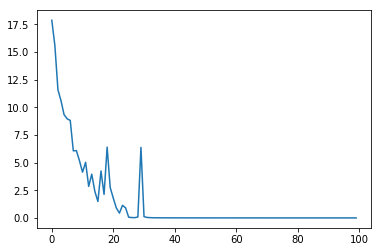

loss on validation set: 0.0008762700426814263
dcba


In [4]:
att_pytorch = AttentionPyTorch(EMBEDDINGS_SIZE, STATE_SIZE)
train(att_pytorch, train_set, val_set)
print(generate(att_pytorch, 'abcd'))